# A successful grape harvesting between weather and resource management

Impor all the relevant libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy import special
import sobol_seq

Import the datasets

In [2]:
wineyard = pd.concat([pd.read_csv('max min.csv',header=0,index_col=0,usecols=[0,3,4]),
                      pd.read_csv('dati dist normale.csv',header=0,index_col=0,usecols=[0,3,4]),
                     pd.read_csv('rese max min.csv',header=0,index_col=0),
                     pd.read_csv('rese media sd.csv',header=0,index_col=0),
                     pd.read_csv('prod max min.csv',header=0,index_col=0),
                     pd.read_csv('prod mean sd.csv',header=0,index_col=0)],axis=1)
wineyard.columns =['Date_max','Date_min','Date_avg','Date_std',
                   'Yield_max','Yield_min','Yield_avg','Yield_std',
                   'Productivity_max','Productivity_min','Productivity_avg','Productivity_std']
# wineyard['Productivity_max']=wineyard.Yield_max/pd.read_csv('max min.csv',index_col=0,header=0,usecols=[0,1,2]).iloc[:,1]
# wineyard['Productivity_min']=wineyard.Yield_min/pd.read_csv('max min.csv',index_col=0,header=0,usecols=[0,1,2]).iloc[:,0]
# wineyard['Productivity_avg']=wineyard[['Yield_max','Yield_min']].mean(axis=1)
# wineyard['Productivity_std']=np.sqrt(wineyard.Yield_avg)
rain = pd.read_csv('pioggia2.csv',header=0,index_col=0).loc[229:306] #Cap it to the days one will be actually using
rain.columns = ['p_5_mm','p_15_mm']
# bottle_prices = pd.read_excel('vitigni vini prezzi.xlsx',header=0,usecols=[1,2]).sort_values(by='Prezzo',ascending=False)

Set the range for the min,max hour-man requirement

In [3]:
hourman = pd.read_csv('max min.csv',header=0,index_col=0,usecols=[0,1,2])
hourman_ranges = [(hourman['OU min'].max()/10).round(0).astype(int),(hourman['OU max'].max()/8).round(0).astype(int)]
hourman_ranges

[8, 17]

These lines are used to define the truncation thresholds for the yields and productivity distributions, which is assumed as the field showing the largest ration (min, max - avg)/std -> 1.2 std

In [4]:
wineyard['Yield_diff_min']=(np.abs(wineyard.Yield_min-wineyard.Yield_avg)/wineyard.Yield_std).round(2)
wineyard['Yield_diff_max']=(np.abs(wineyard.Yield_max-wineyard.Yield_avg)/wineyard.Yield_std).round(2)
wineyard['Productivity_diff_min']=(np.abs(wineyard.Productivity_min-wineyard.Productivity_avg)/wineyard.Productivity_std).round(2)
wineyard['Productivity_diff_max']=(np.abs(wineyard.Productivity_max-wineyard.Productivity_avg)/wineyard.Productivity_std).round(2)

In [5]:
wineyard['Date_lower']= 229 #August 16
wineyard['Date_upper']= 305 #October 31, leap year

wineyard['Yield_lower']= wineyard.Yield_avg-wineyard.Yield_std*1.2 #Driven by the max possible variability across wineyards
wineyard['Yield_upper']= wineyard.Yield_avg+wineyard.Yield_std*1.2 #Driven by the max possible variability across wineyards
wineyard['Productivity_lower']= wineyard.Productivity_avg-wineyard.Productivity_std*1.2 #Driven by the max possible variability across wineyards
wineyard['Productivity_upper']= wineyard.Productivity_avg+wineyard.Productivity_std*1.2 #Driven by the max possible variability across wineyards

# wineyard['vitigni']=pd.read_csv('vigneti vitigni.csv',header=0,index_col=0,usecols=[0,1])
# wineyard=wineyard.set_index([wineyard.index,'vitigni'])

The base matrix for the distribution is then imported

In [6]:
# trigger manpower distribution, trigger date distribution, 
# manpower normal distribution, manpower uniform distribution, date normal distribution, date manpower distribution
# trigger rain, rain 5 mm, rain 15 mm
# trigger extra hours, work on Sundays, weekly call
sampleTot = sobol_seq.i4_sobol_generate(40,-1+2**13).T

And the individual distributions produced as per the features agreed

In [7]:
sample_rain_5 = []
sample_rain_15 = []
sample_rain_5B = []
sample_rain_15B = []
for i,row in rain.iterrows():
    sample_rain_5.append(rain.loc[i,'p_5_mm']<sampleTot[28])
    sample_rain_15.append(rain.loc[i,'p_15_mm']<sampleTot[28])
    sample_rain_5B.append(rain.loc[i,'p_5_mm']<sampleTot[29])
    sample_rain_15B.append(rain.loc[i,'p_15_mm']<sampleTot[29])
sample_rain = pd.DataFrame(([np.concatenate(sample_rain_5),np.concatenate(sample_rain_15)]),index=['rain_5mm','rain_15mm']).T
sample_rainB = pd.DataFrame(([np.concatenate(sample_rain_5B),np.concatenate(sample_rain_15B)]),index=['rain_5mm','rain_15mm']).T
sample_rain.index = [ri for ri in rain.index for r in range(len(sampleTot.T))]
sample_rain['random_index']=[r for q in range(len(rain)) for r in range(len(sampleTot.T))]
sample_rain = sample_rain.set_index([sample_rain.index,'random_index'])
sample_rainB.index=sample_rain.index
# sample_rain

In [8]:
sample = pd.concat([pd.concat([pd.Series(wineyard.Yield_avg.loc[i]+np.sqrt(2)*wineyard.Yield_std.loc[i]*special.erfinv(
    sampleTot[0]*special.erf((wineyard.Yield_upper.loc[i]-wineyard.Yield_avg.loc[i])/(np.sqrt(2)*wineyard.Yield_std.loc[i]))+
    (1-sampleTot[0])*special.erf((wineyard.Yield_lower.loc[i]-wineyard.Yield_avg).loc[i]/(np.sqrt(2)*wineyard.Yield_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Yield_min.loc[i]+(wineyard.Yield_max.loc[i]-wineyard.Yield_min.loc[i])*sampleTot[1])
                    for i, row in wineyard.iterrows()]),
                    pd.concat([pd.Series(wineyard.Productivity_avg.loc[i]+np.sqrt(2)*wineyard.Productivity_std.loc[i]*special.erfinv(
    sampleTot[2]*special.erf((wineyard.Productivity_upper.loc[i]-wineyard.Productivity_avg.loc[i])/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))+
    (1-sampleTot[2])*special.erf((wineyard.Productivity_lower.loc[i]-wineyard.Productivity_avg).loc[i]/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Productivity_min.loc[i]+(wineyard.Productivity_max.loc[i]-wineyard.Productivity_min.loc[i])*sampleTot[3])
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_avg.loc[i]+np.sqrt(2)*wineyard.Date_std.loc[i]*special.erfinv(
    sampleTot[4]*special.erf((wineyard.Date_upper.loc[i]-wineyard.Date_avg.loc[i])/(np.sqrt(2)*wineyard.Date_std.loc[i]))+
    (1-sampleTot[4])*special.erf((wineyard.Date_lower.loc[i]-wineyard.Date_avg).loc[i]/(np.sqrt(2)*wineyard.Date_std.loc[i])))).astype(int)
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_min.loc[i]+(wineyard.Date_max.loc[i]-wineyard.Date_min.loc[i])*sampleTot[5]).astype(int)
                    for i, row in wineyard.iterrows()])],axis=1)
sample.columns = ['Yield_gaussian','Yield_uniform',
                  'Productivity_gaussian','Productivity_uniform',
                  'Date_gaussian','Date_uniform']
sample.index = [wi for wi in wineyard.index for r in range(len(sampleTot.T))]
sample['Yield_trigger']=sample.columns[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))]
sample['Productivity_trigger']=sample.columns[np.tile((sampleTot[7]+2).round(0).astype(int), len(wineyard))]
sample['Date_trigger']=sample.columns[np.tile((sampleTot[8]+4).round(0).astype(int), len(wineyard))]
sample['Workers']=np.tile((sampleTot[9]*(max(hourman_ranges)-min(hourman_ranges))+\
                                                  min(hourman_ranges)).round(0).astype(int), len(wineyard))
sample['Rain_trigger']=sample_rain.columns[np.tile(sampleTot[10].round(0).astype(int), len(wineyard))]
sample['Hours_extra']=np.tile(8+(sampleTot[11]).round(0).astype(int)*2, len(wineyard))
sample['Sundays_work']=np.tile(sampleTot[12]<0.1, len(wineyard))
sample['Sundays']=np.tile(pd.Series([[(q*7).astype(int)+229+7*r for r in range(11)] for q in sampleTot[13]]),len(wineyard))
# sample['Weekly_call']=np.tile(sampleTot[12]<0.5, len(wineyard))
sample['random_index']=[r for q in range(len(wineyard)) for r in range(len(sampleTot.T))]
# sample = sample.set_index([pd.MultiIndex.from_tuples(sample.index.get_level_values(0)),'random_index'])
sample = sample.set_index([sample.index,'random_index'])
# sample

sampleB = pd.concat([pd.concat([pd.Series(wineyard.Yield_avg.loc[i]+np.sqrt(2)*wineyard.Yield_std.loc[i]*special.erfinv(
    sampleTot[14]*special.erf((wineyard.Yield_upper.loc[i]-wineyard.Yield_avg.loc[i])/(np.sqrt(2)*wineyard.Yield_std.loc[i]))+
    (1-sampleTot[14])*special.erf((wineyard.Yield_lower.loc[i]-wineyard.Yield_avg).loc[i]/(np.sqrt(2)*wineyard.Yield_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Yield_min.loc[i]+(wineyard.Yield_max.loc[i]-wineyard.Yield_min.loc[i])*sampleTot[15])
                    for i, row in wineyard.iterrows()]),
                    pd.concat([pd.Series(wineyard.Productivity_avg.loc[i]+np.sqrt(2)*wineyard.Productivity_std.loc[i]*special.erfinv(
    sampleTot[16]*special.erf((wineyard.Productivity_upper.loc[i]-wineyard.Productivity_avg.loc[i])/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))+
    (1-sampleTot[16])*special.erf((wineyard.Productivity_lower.loc[i]-wineyard.Productivity_avg).loc[i]/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Productivity_min.loc[i]+(wineyard.Productivity_max.loc[i]-wineyard.Productivity_min.loc[i])*sampleTot[17])
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_avg.loc[i]+np.sqrt(2)*wineyard.Date_std.loc[i]*special.erfinv(
    sampleTot[18]*special.erf((wineyard.Date_upper.loc[i]-wineyard.Date_avg.loc[i])/(np.sqrt(2)*wineyard.Date_std.loc[i]))+
    (1-sampleTot[18])*special.erf((wineyard.Date_lower.loc[i]-wineyard.Date_avg).loc[i]/(np.sqrt(2)*wineyard.Date_std.loc[i])))).astype(int)
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_min.loc[i]+(wineyard.Date_max.loc[i]-wineyard.Date_min.loc[i])*sampleTot[19]).astype(int)
                    for i, row in wineyard.iterrows()])],axis=1)
sampleB.columns = ['Yield_gaussian','Yield_uniform',
                  'Productivity_gaussian','Productivity_uniform',
                  'Date_gaussian','Date_uniform']
sampleB.index = [wi for wi in wineyard.index for r in range(len(sampleTot.T))]
sampleB['Yield_trigger']=sampleB.columns[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))]
sampleB['Productivity_trigger']=sampleB.columns[np.tile((sampleTot[21]+2).round(0).astype(int), len(wineyard))]
sampleB['Date_trigger']=sampleB.columns[np.tile((sampleTot[22]+4).round(0).astype(int), len(wineyard))]

sampleB['Workers']=np.tile((sampleTot[23]*(max(hourman_ranges)-min(hourman_ranges))+\
                                                  min(hourman_ranges)).round(0).astype(int), len(wineyard))
sampleB['Rain_trigger']=sample_rainB.columns[np.tile(sampleTot[24].round(0).astype(int), len(wineyard))]
sampleB['Hours_extra']=np.tile(8+(sampleTot[25]).round(0).astype(int)*2, len(wineyard))
sampleB['Sundays_work']=np.tile(sampleTot[26]<0.1, len(wineyard))
sampleB['Sundays']=np.tile(pd.Series([[(q*7).astype(int)+229+7*r for r in range(11)] for q in sampleTot[27]]),len(wineyard))
# sample['Weekly_call']=np.tile(sampleTot[12]<0.5, len(wineyard))
sampleB['random_index']=[r for q in range(len(wineyard)) for r in range(len(sampleTot.T))]
# sample = sample.set_index([pd.MultiIndex.from_tuples(sample.index.get_level_values(0)),'random_index'])
sampleB = sampleB.set_index([sampleB.index,'random_index'])

Produce the scrambled matrices

In [9]:
variables = ['Yield_gaussian','Yield_uniform','Productivity_gaussian','Productivity_uniform',
             'Date_gaussian','Date_uniform','Yield','Productivity','Date',
            'Workers','Rain_trigger','Hours_extra','Sundays_work','Sundays','Rain']

yield_list, productivity_list, date_list = [],[],[]
for es,s in enumerate(sampleB.iloc[:,:2].values):
    yield_list.append(s[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))[es]])
    productivity_list.append(sampleB.iloc[es,2:4][np.tile(sampleTot[21].round(0).astype(int), len(wineyard))[es]])
    date_list.append(sampleB.iloc[es,4:6][np.tile(sampleTot[22].round(0).astype(int), len(wineyard))[es]])
    
sampleB['Yield']= yield_list
sampleB['Productivity']= productivity_list
sampleB['Date']= date_list

sampleB['Hourman']=(sampleB.Yield/sampleB.Productivity).round(0).astype(int)

yield_list, productivity_list, date_list = [],[],[]
for es,s in enumerate(sample.iloc[:,:2].values):
    yield_list.append(s[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))[es]])
    productivity_list.append(sample.iloc[es,2:4][np.tile(sampleTot[7].round(0).astype(int), len(wineyard))[es]])
    date_list.append(sample.iloc[es,4:6][np.tile(sampleTot[8].round(0).astype(int), len(wineyard))[es]])
    
sample['Yield']= yield_list
sample['Productivity']= productivity_list
sample['Date']= date_list

sample['Hourman']=(sample.Yield/sample.Productivity).round(0).astype(int)

sM_A=[sample]

sample_requirement=pd.DataFrame(sample.groupby(['random_index','Date'])['Hourman'].sum())

days_worked_dict = {}
for es,s in sample.groupby(level=1):
    days_no_rain = rain.index[sample_rain.loc[pd.IndexSlice[:,es],s.loc['vigneto 1','Rain_trigger'].values[0]]]
    days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
    if s.loc['vigneto 1','Sundays_work'].values[0] == False:
        days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc['vigneto 1','Sundays'].values[0])])
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
    else:
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
manpower_available.columns=['Hourman']

difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)

# difference.loc[difference.Hourman<0,'Hourman']=0

sample_requirement = sample_requirement.reset_index()
sample_requirement.index = sample_requirement.random_index

output = pd.concat([(np.abs(sample_requirement.Hourman-\
sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                    sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                   difference.groupby('random_index').sum()],axis=1)
output.columns = ['Hourman_discrepancy','Maturation_date_discrepancy','Hourman_deficit']

output_list = [output]

for iv, v in enumerate(variables):
    sM_A.append(sample.copy())
    if v != 'Rain':
        sM_A[-1][v]=sampleB[v]
    
    yield_list, productivity_list, date_list = [],[],[]
    for es,s in enumerate(sM_A[-1].iloc[:,:2].values):
        if iv == 6:
            yield_list.append(s[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))[es]])
        else:
            yield_list.append(s[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))[es]])
        if iv == 7:
            productivity_list.append(sM_A[-1].iloc[es,2:4][np.tile(sampleTot[21].round(0).astype(int), len(wineyard))[es]])
        else:
            productivity_list.append(sM_A[-1].iloc[es,2:4][np.tile(sampleTot[7].round(0).astype(int), len(wineyard))[es]])
        if iv == 8:
            date_list.append(sM_A[-1].iloc[es,4:6][np.tile(sampleTot[22].round(0).astype(int), len(wineyard))[es]])
        else:
            date_list.append(sM_A[-1].iloc[es,4:6][np.tile(sampleTot[8].round(0).astype(int), len(wineyard))[es]])

    sM_A[-1]['Yield']= yield_list
    sM_A[-1]['Productivity']= productivity_list
    sM_A[-1]['Date']= date_list
       
    sM_A[-1]['Hourman']=(sM_A[-1].Yield/sM_A[-1].Productivity).round(0).astype(int)
    
    sample_requirement=pd.DataFrame(sM_A[-1].groupby(['random_index','Date'])['Hourman'].sum())

    #set_days_available_when_not_raining and exclude Sundays if not in the trigger
    days_worked_dict = {}
    for es,s in sM_A[-1].groupby(level=1):
        if iv == 14:
            days_no_rain = rain.index[sample_rainB.loc[pd.IndexSlice[:,es],s.loc['vigneto 1','Rain_trigger'].values[0]]]
        else:
            days_no_rain = rain.index[sample_rain.loc[pd.IndexSlice[:,es],s.loc['vigneto 1','Rain_trigger'].values[0]]]
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
        if s.loc['vigneto 1','Sundays_work'].values[0] == False:
            days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc['vigneto 1','Sundays'].values[0])])
            days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
        else:
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

    manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
    manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
    manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

    manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
    manpower_available.columns=['Hourman']

    difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)
    
#     difference.loc[difference.Hourman<0,'Hourman']=0


    sample_requirement = sample_requirement.reset_index()
    sample_requirement.index = sample_requirement.random_index

    output = pd.concat([(np.abs(sample_requirement.Hourman-\
    sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                        sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                       difference.groupby('random_index').sum()],axis=1)
    output.columns = ['Hourman_discrepancy','Maturation_date_discrepancy','Hourman_deficit']
    output_list.append(output)
    
sM_A.append(sampleB)

sample_requirement=pd.DataFrame(sampleB.groupby(['random_index','Date'])['Hourman'].sum())

days_worked_dict = {}
for es,s in sampleB.groupby(level=1):
    days_no_rain = rain.index[sample_rainB.loc[pd.IndexSlice[:,es],s.loc['vigneto 1','Rain_trigger'].values[0]]]
    days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
    if s.loc['vigneto 1','Sundays_work'].values[0] == False:
        days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc['vigneto 1','Sundays'].values[0])])
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
    else:
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
manpower_available.columns=['Hourman']

difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)

# difference.loc[difference.Hourman<0,'Hourman']=0

sample_requirement = sample_requirement.reset_index()
sample_requirement.index = sample_requirement.random_index

output = pd.concat([(np.abs(sample_requirement.Hourman-\
sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                    sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                   difference.groupby('random_index').sum()],axis=1)
output.columns = ['Hourman_discrepancy','Maturation_date_discrepancy','Hourman_deficit']
output_list.append(output)

Slice the dataframe by fixing the number of workers

In [10]:
workers_index = [sM_A[0][sM_A[0].Workers==s].index.get_level_values(1).drop_duplicates()
                 for s in np.sort(sM_A[0].Workers.unique())]

extrahours_index = [sM_A[0][sM_A[0].Hours_extra==s].index.get_level_values(1).drop_duplicates()
                 for s in np.sort(sM_A[0].Hours_extra.unique())]

Hourman_deficit_worker = [output_list[0].loc[w,'Hourman_deficit'] for w in workers_index]
Hourman_deficit_extrahours = [output_list[0].loc[h,'Hourman_deficit'] for h in extrahours_index]

Hourman_deficit_worker_df = pd.concat(Hourman_deficit_worker,axis=1)
Hourman_deficit_extrahours_df = pd.concat(Hourman_deficit_extrahours,axis=1)
Hourman_deficit_worker_df.columns = np.sort(sM_A[0].Workers.unique())
Hourman_deficit_extrahours_df.columns = np.sort(sM_A[0].Hours_extra.unique())

Assess the sensitivity indices

In [26]:
Var = pd.concat([output_list[0],output_list[-1]],axis=0).var(ddof=0)
T_list = []
S_list = []
for eo, o in enumerate(output_list[1:-1]):
    T_list.append(0.5*np.mean((o-output_list[0])**2)/Var)
    S_list.append(np.mean(output_list[-1]*(o-output_list[0]))/Var)
T = pd.concat(T_list,axis=1)
T.columns = variables
S = pd.concat(S_list,axis=1)
S.columns = T.columns

Assess the sensitivity indices - bootstrap

In [27]:
seed = output_list[0].sample(n=1_000*len(output_list[0]),replace=True).index
new_index = [r for r in range(1000) for i in range(-1+2**13)]
output_bootstrap = []
for o in output_list:
    o_df = o.reindex(seed)
    o_df.index = new_index
    output_bootstrap.append(o_df)
Var = pd.concat([output_bootstrap[0],output_bootstrap[-1]],axis=0).groupby(pd.concat([output_bootstrap[0],
                                                            output_bootstrap[-1]],axis=0).index).var(ddof=0)
T_list = []
S_list = []
for eo, o in enumerate(output_bootstrap[1:-1]):
    T_list.append(0.5*((o-output_bootstrap[0])**2).groupby(o.index).mean()/Var)
    S_list.append((output_bootstrap[-1]*(o-output_bootstrap[0])).groupby(o.index).mean()/Var)
T_output = [pd.concat([T.iloc[:,c] for T in T_list],axis=1) for c in range(len(T_list[0].columns))]
S_output = [pd.concat([S.iloc[:,c] for S in S_list],axis=1) for c in range(len(S_list[0].columns))]
for To in T_output:
    To.columns=variables 
for So in S_output:
    So.columns=variables

Assess the sensitivity indices - fixed number of workers

# Visual output

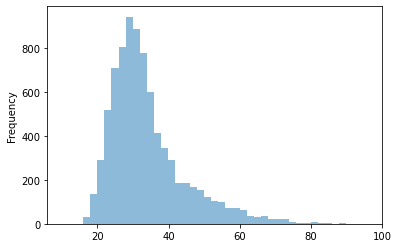

In [28]:
output_list[0].Hourman_discrepancy.plot.hist(bins=100,alpha=.5)
plt.xlim(right=100)
plt.show()

In [29]:
output_list[0].Hourman_discrepancy.describe()

count    8191.000000
mean       34.009714
std        10.905855
min        15.934066
25%        26.904587
50%        31.423077
75%        38.071429
max       215.933333
Name: Hourman_discrepancy, dtype: float64

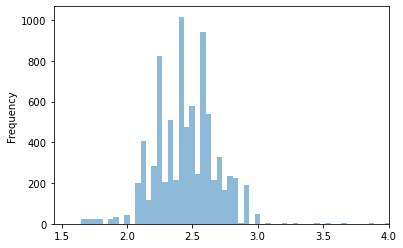

In [30]:
output_list[0].Maturation_date_discrepancy.plot.hist(bins=100,alpha=.5)
plt.xlim(right=4)
plt.show()

In [31]:
output_list[0].Maturation_date_discrepancy.describe()

count    8191.000000
mean        2.450699
std         0.236859
min         1.647059
25%         2.285714
50%         2.466667
75%         2.583333
max         5.800000
Name: Maturation_date_discrepancy, dtype: float64

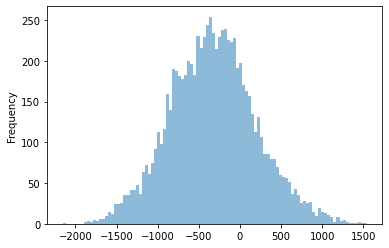

In [32]:
output_list[0].Hourman_deficit.plot.hist(bins=100,alpha=.5)

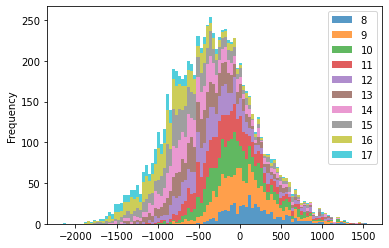

In [33]:
Hourman_deficit_worker_df.plot.hist(stacked=True,bins=100,alpha=.75)

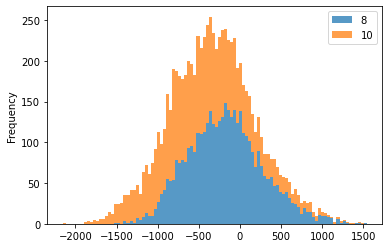

In [34]:
Hourman_deficit_extrahours_df.plot.hist(stacked=True,bins=100,alpha=.75)

In [35]:
lots_workers_failing = output_list[0].Hourman_deficit.loc[sample[sample.Workers==17].index.get_level_values(1).drop_duplicates()].index.intersection(
output_list[0].Hourman_deficit.loc[output_list[0].Hourman_deficit>0].index)

In [36]:
len(lots_workers_failing)

39

In [37]:
requirement_lots_worker_failing=pd.DataFrame(sample.loc[:,pd.IndexSlice[lots_workers_failing],:].groupby(['random_index','Date'])['Hourman'].sum())

In [38]:
output_list[0].Hourman_deficit.describe()

count    8191.000000
mean     -327.845562
std       522.147106
min     -2157.000000
25%      -688.000000
50%      -336.000000
75%         4.000000
max      1542.000000
Name: Hourman_deficit, dtype: float64

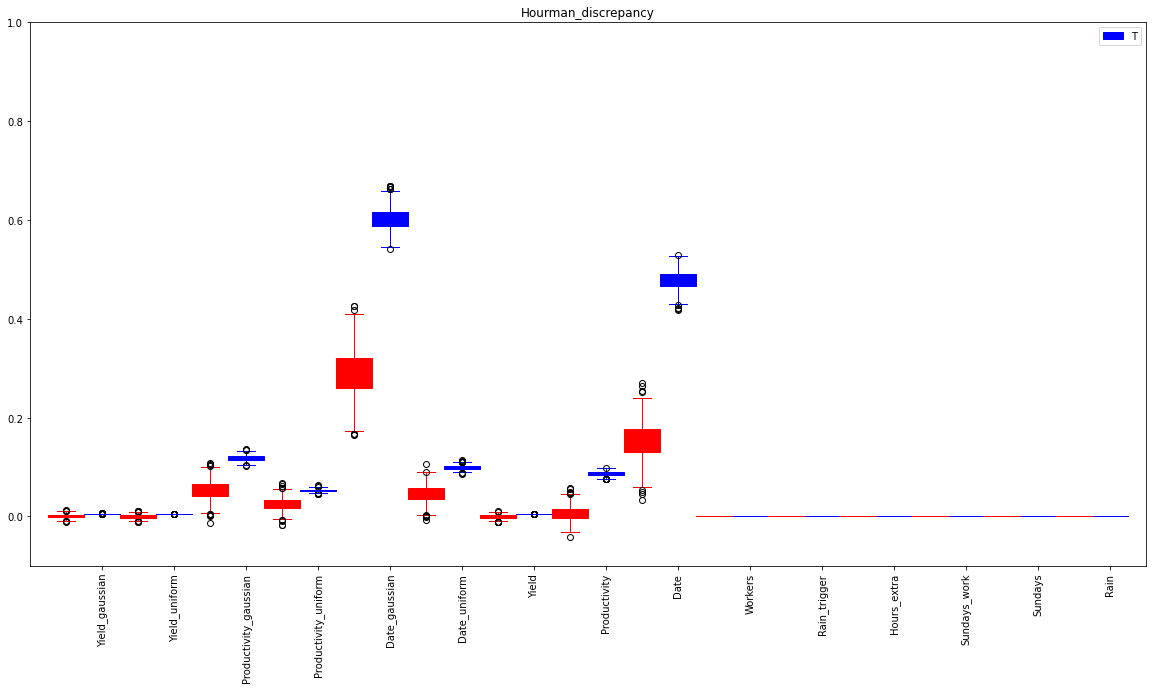

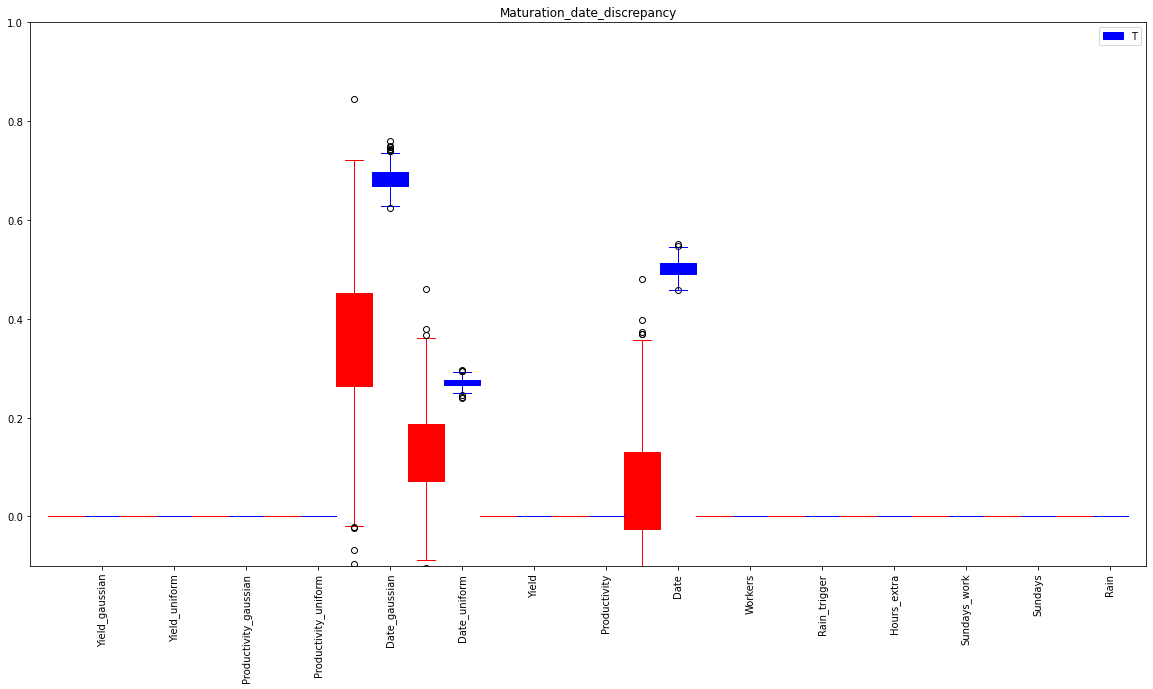

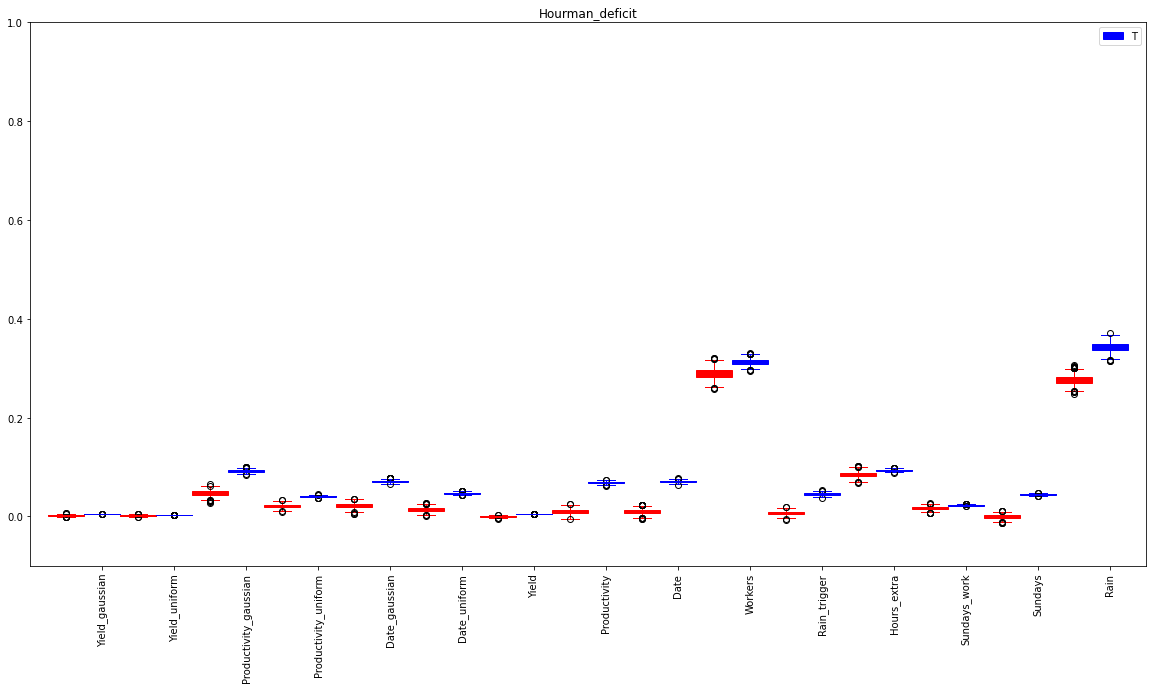

In [39]:
for it,To in enumerate(T_output):
    fig, ax = plt.subplots(figsize=(20,10))
#     for iv,v in enumerate(variables):
#     ax.set_xticklabels(labels=variables,rotation='vertical')
    To.plot(kind='box',ax=ax,label='T', color='b',patch_artist=True)
#     To.plot(kind='box',label='T', color='b',patch_artist=True)
    S_output[it].plot(kind='box',ax=ax,label='S',positions=[iv+0.5 for iv in range(len(variables))],
                                              color='r',patch_artist=True)
#     S_output[it].plot(kind='box',ax=ax,label='S',
#                                               color='r',patch_artist=True)
    m_patch = mpatches.Patch(color='b', label='T')
    c_patch = mpatches.Patch(color='r', label='S')
    plt.xticks([iv+1 for iv in range(len(variables))],labels=variables,rotation='vertical')
    plt.legend(handles=[m_patch,c_patch])
    plt.xlim(0,15.5)
    plt.ylim(-.1,1)
    plt.title(output_list[it].columns[it])
    plt.legend(handles=[m_patch])
    fig = plt.plot(figsize=(20,10),dpi=1000)
    plt.show()
    
#     S_output[it].plot(kind='box',label='S',
#                                               color='r',patch_artist=True)
#     c_patch = mpatches.Patch(color='r', label='S')
#     plt.legend(handles=[c_patch])
# #     plt.legend(handles=[m_patch])
#     plt.xticks([iv+1 for iv in range(len(variables))],labels=variables,rotation='vertical')
#     plt.xlim(0,15.5)
#     plt.ylim(-.1,1)
#     plt.title(output_list[it].columns[it])
#     plt.plot(figsize=(20,10),dpi=300)
#     plt.show()

In [40]:
T_output[-1][['Workers','Rain']].sum(axis=1).describe()

count    1000.000000
mean        0.655074
std         0.010813
min         0.617615
25%         0.647595
50%         0.654817
75%         0.661975
max         0.690025
dtype: float64

In [41]:
S_output[-1][['Workers','Rain']].sum(axis=1).describe()

count    1000.000000
mean        0.565524
std         0.013521
min         0.522639
25%         0.556639
50%         0.565364
75%         0.574369
max         0.612511
dtype: float64

In [42]:
for s in S_output[-1]:
    print(S_output[-1][s].describe())

count    1000.000000
mean        0.002055
std         0.001279
min        -0.001711
25%         0.001209
50%         0.002030
75%         0.002959
max         0.006000
Name: Yield_gaussian, dtype: float64
count    1000.000000
mean        0.001747
std         0.001082
min        -0.001412
25%         0.001047
50%         0.001749
75%         0.002482
max         0.004890
Name: Yield_uniform, dtype: float64
count    1000.000000
mean        0.046789
std         0.005389
min         0.027327
25%         0.043280
50%         0.047013
75%         0.050402
max         0.064871
Name: Productivity_gaussian, dtype: float64
count    1000.000000
mean        0.020857
std         0.003797
min         0.009554
25%         0.018096
50%         0.020954
75%         0.023423
max         0.033610
Name: Productivity_uniform, dtype: float64
count    1000.000000
mean        0.022197
std         0.004865
min         0.004435
25%         0.018821
50%         0.022133
75%         0.025415
max         0.036114


In [43]:
S_output[-1].sum(axis=1).describe()

count    1000.000000
mean        0.798603
std         0.021291
min         0.714897
25%         0.784756
50%         0.798118
75%         0.813411
max         0.884027
dtype: float64

In [44]:
T_output[-1].sum(axis=1).describe()

count    1000.000000
mean        1.263914
std         0.015871
min         1.219200
25%         1.252866
50%         1.263950
75%         1.274477
max         1.312236
dtype: float64

In [45]:
for t in T_output[-1]:
    print(T_output[-1][t].describe())

count    1000.000000
mean        0.005129
std         0.000142
min         0.004691
25%         0.005033
50%         0.005124
75%         0.005221
max         0.005534
Name: Yield_gaussian, dtype: float64
count    1000.000000
mean        0.003440
std         0.000093
min         0.003165
25%         0.003378
50%         0.003437
75%         0.003503
max         0.003779
Name: Yield_uniform, dtype: float64
count    1000.000000
mean        0.091486
std         0.002484
min         0.083198
25%         0.089851
50%         0.091436
75%         0.093073
max         0.100037
Name: Productivity_gaussian, dtype: float64
count    1000.000000
mean        0.040825
std         0.001084
min         0.036967
25%         0.040064
50%         0.040826
75%         0.041601
max         0.044403
Name: Productivity_uniform, dtype: float64
count    1000.000000
mean        0.070869
std         0.002139
min         0.064520
25%         0.069416
50%         0.070743
75%         0.072320
max         0.078328


In [46]:
variables_no_Workers = ['Yield_gaussian','Yield_uniform','Productivity_gaussian','Productivity_uniform',
             'Date_gaussian','Date_uniform','Yield','Productivity','Date',
            'Rain_trigger','Hours_extra','Sundays_work','Sundays','Rain']
Hourman_deficit_worker_list = []
for h in Hourman_deficit_worker:
    seed = h.sample(n=1_000*len(h),replace=True).index
    new_index = [r for r in range(1000) for i in range(len(h))]
    output_bootstrap = []
    for o in output_list:
        o_df = o.Hourman_deficit.reindex(seed)
        o_df.index = new_index
        output_bootstrap.append(o_df)
    Var = pd.concat([output_bootstrap[0],output_bootstrap[-1]],axis=0).groupby(pd.concat([output_bootstrap[0],
                                                                output_bootstrap[-1]],axis=0).index).var(ddof=0)
    T_list = []
    S_list = []
    for eo, o in enumerate(output_bootstrap[1:-1]):
        if eo == 9:
            pass
        else:
            T_list.append(0.5*((o-output_bootstrap[0])**2).groupby(o.index).mean()/Var)
            S_list.append((output_bootstrap[-1]*(o-output_bootstrap[0])).groupby(o.index).mean()/Var)
    T_output = pd.concat(T_list,axis=1)
    S_output = pd.concat(S_list,axis=1)
    T_output.columns=variables_no_Workers
    S_output.columns=variables_no_Workers
    Hourman_deficit_worker_list.append([S_output,T_output])

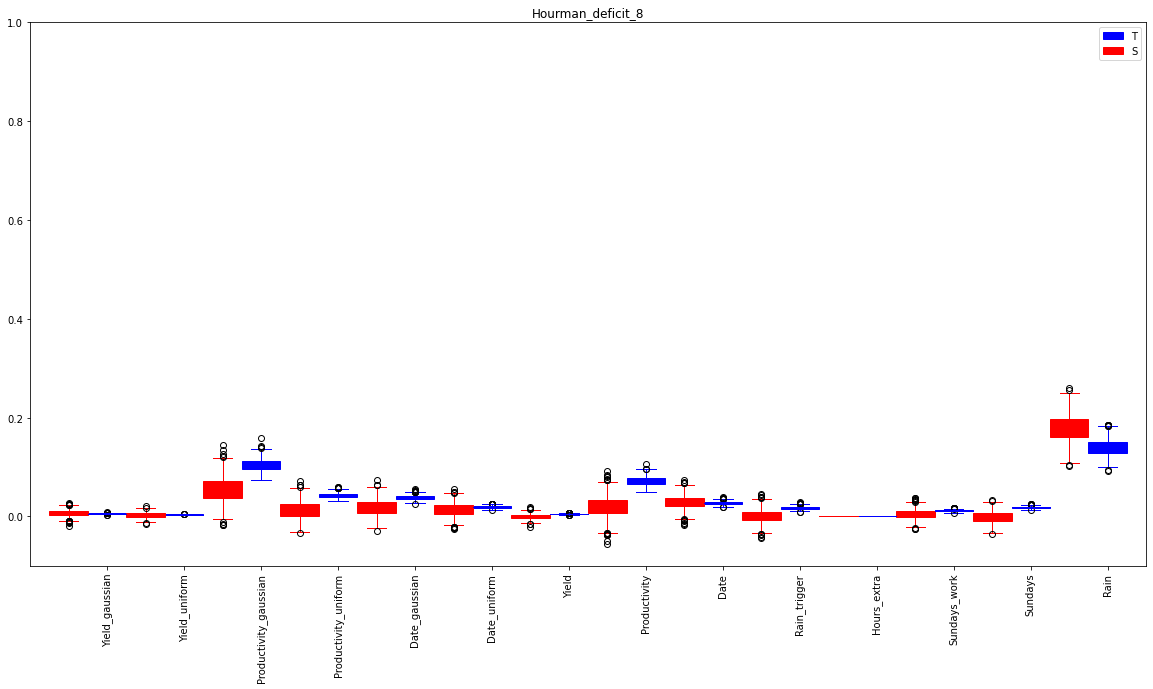

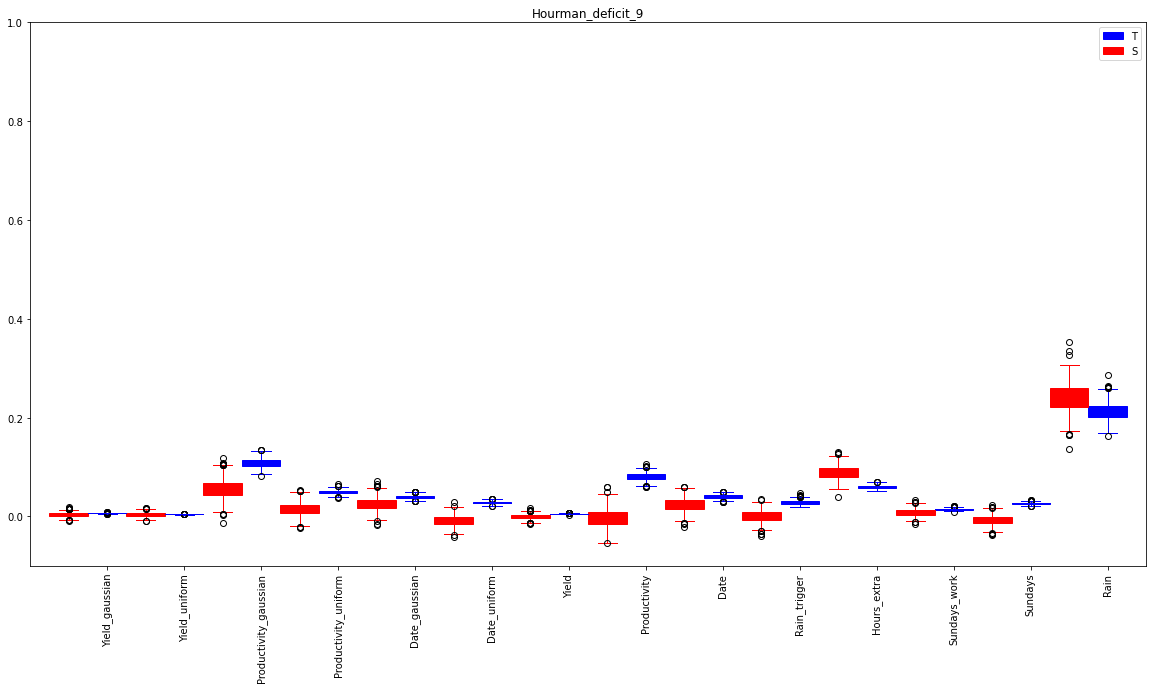

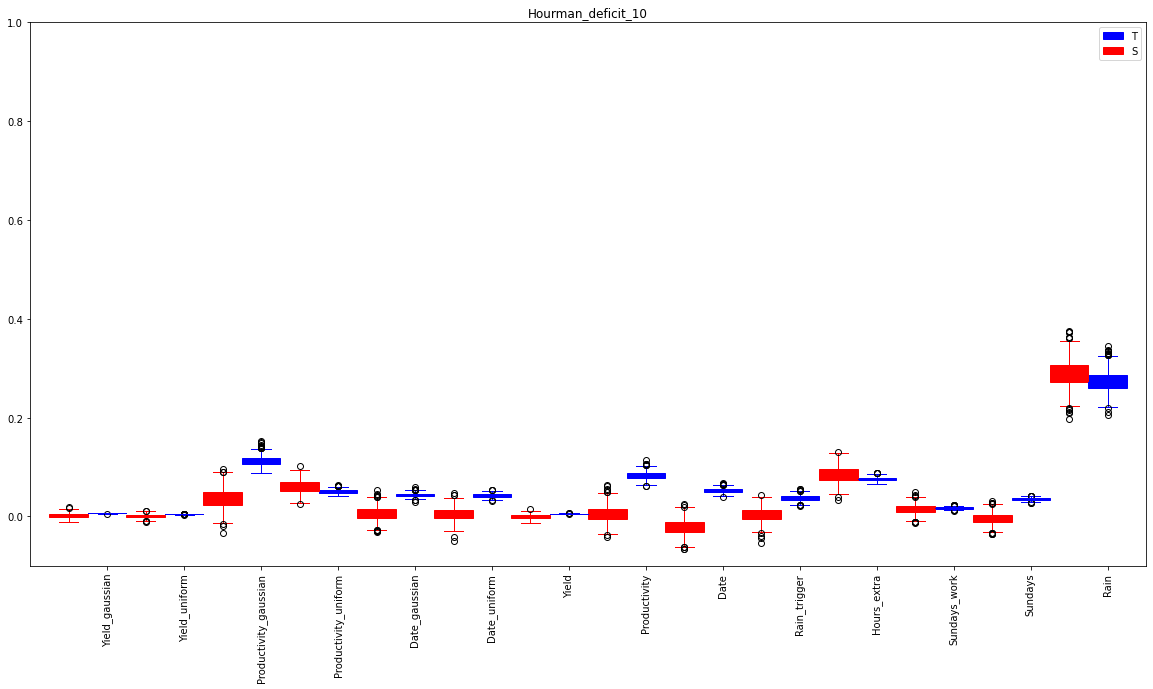

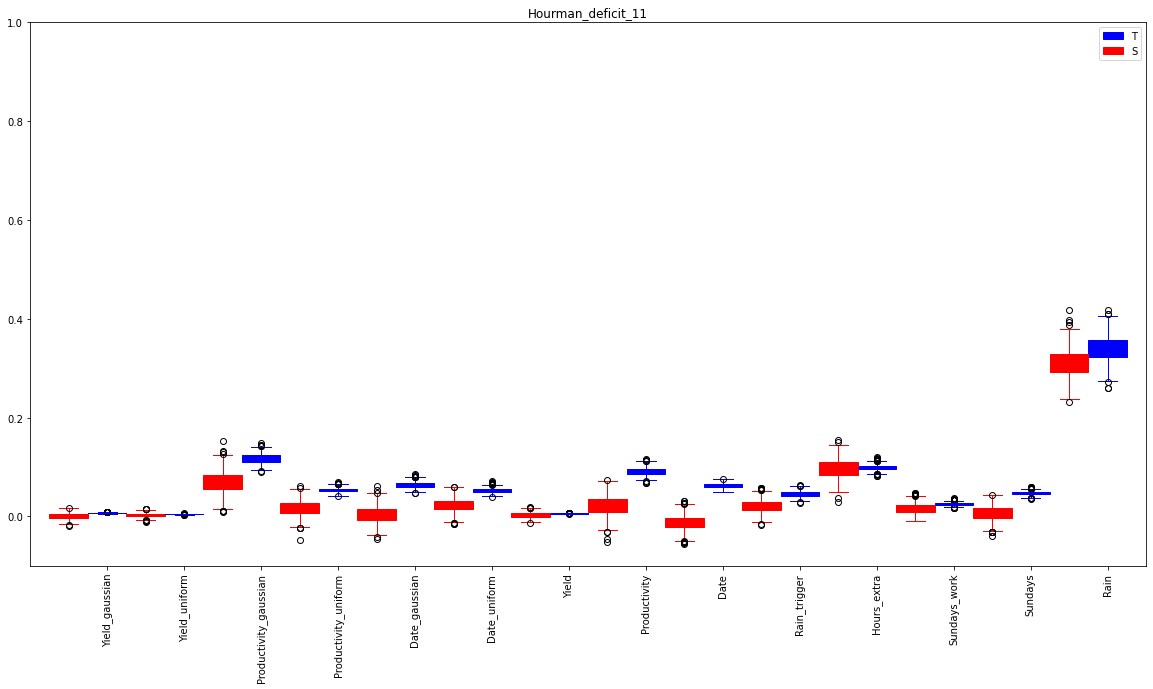

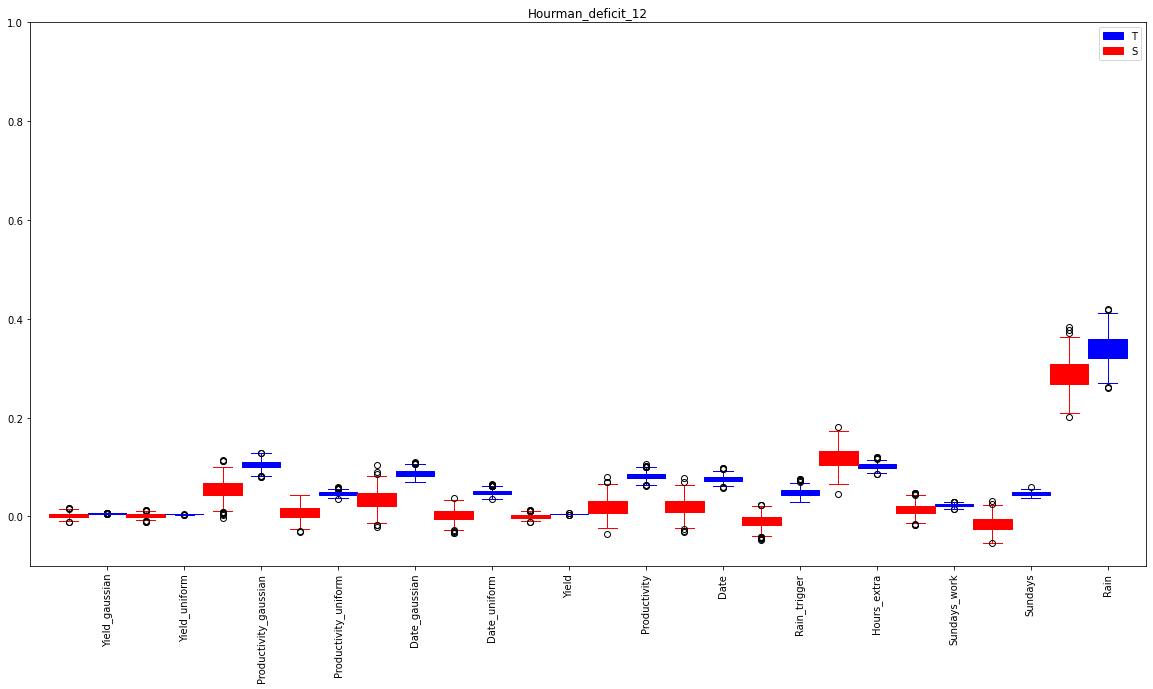

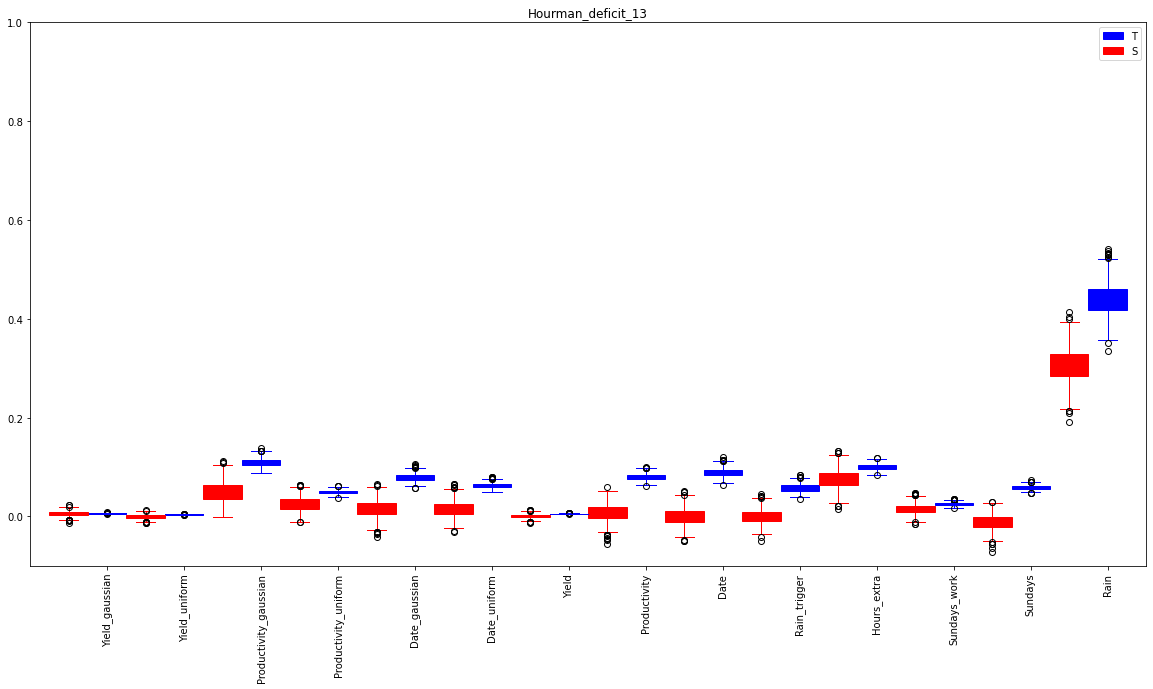

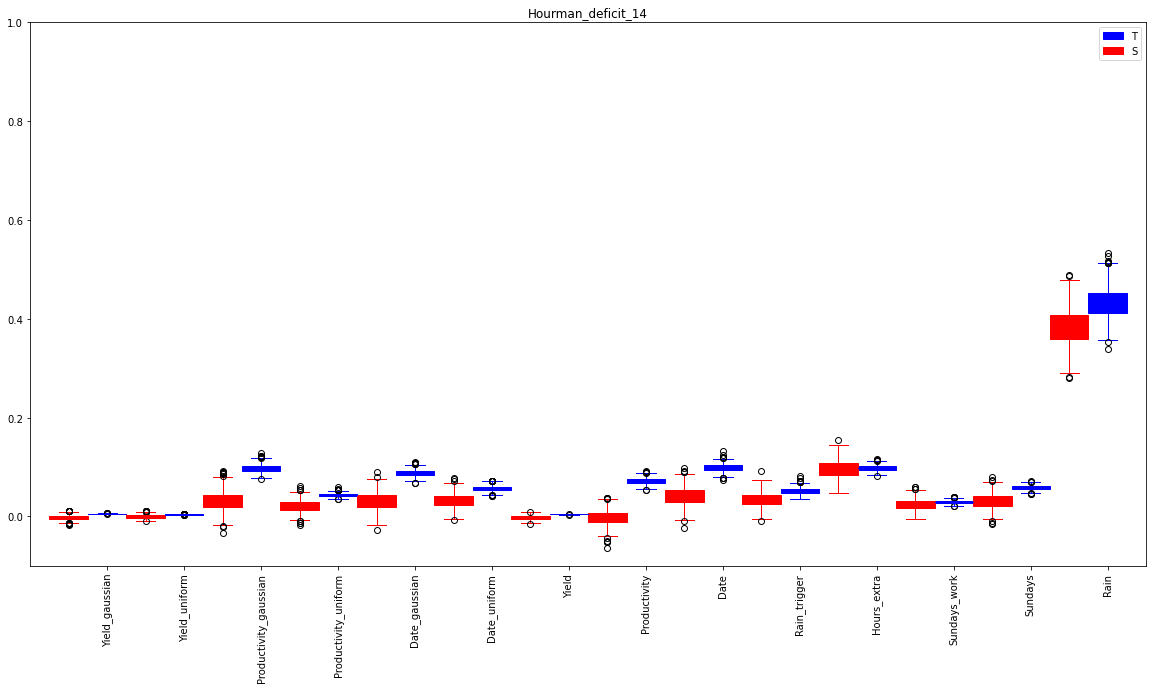

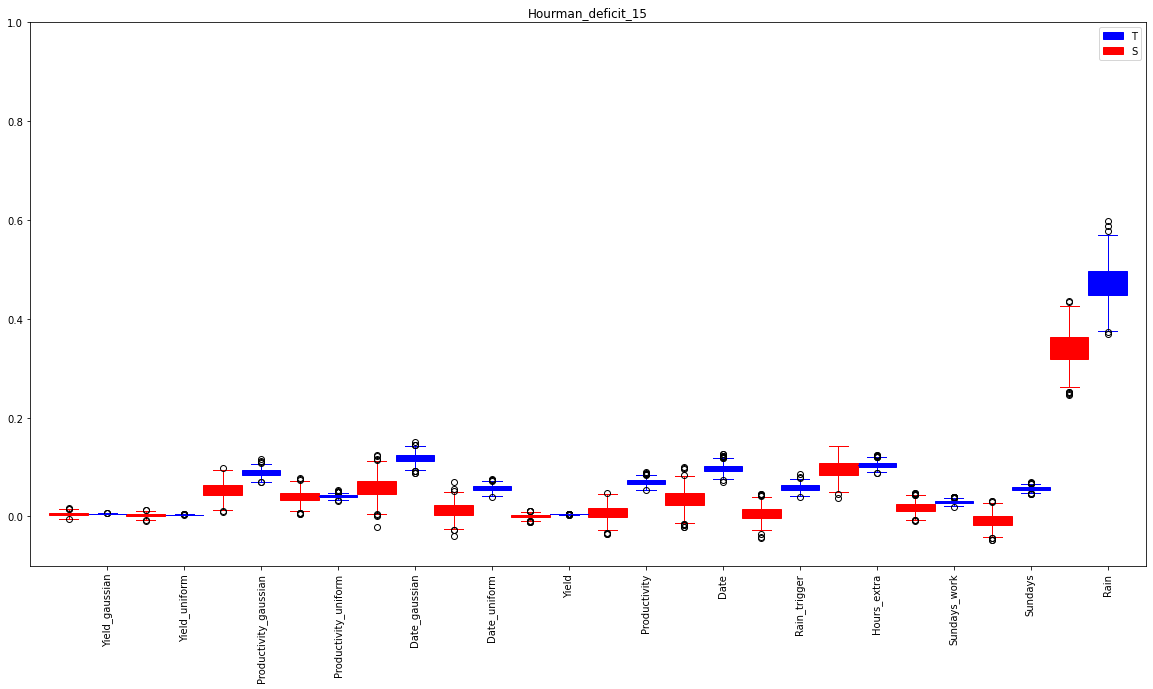

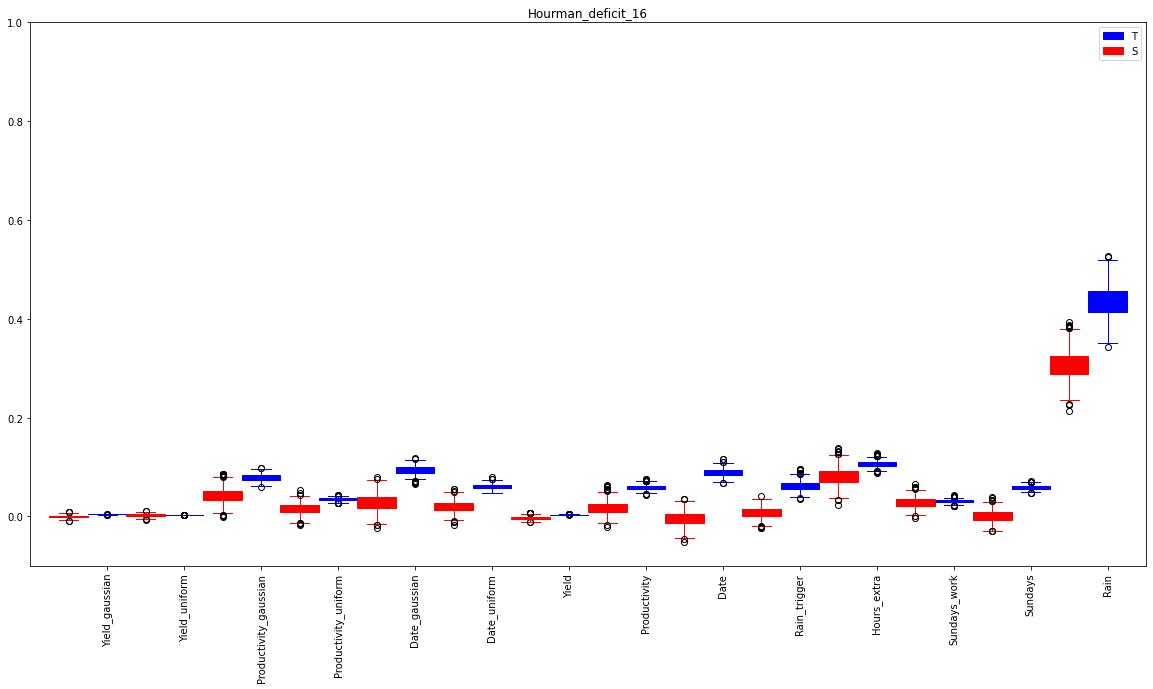

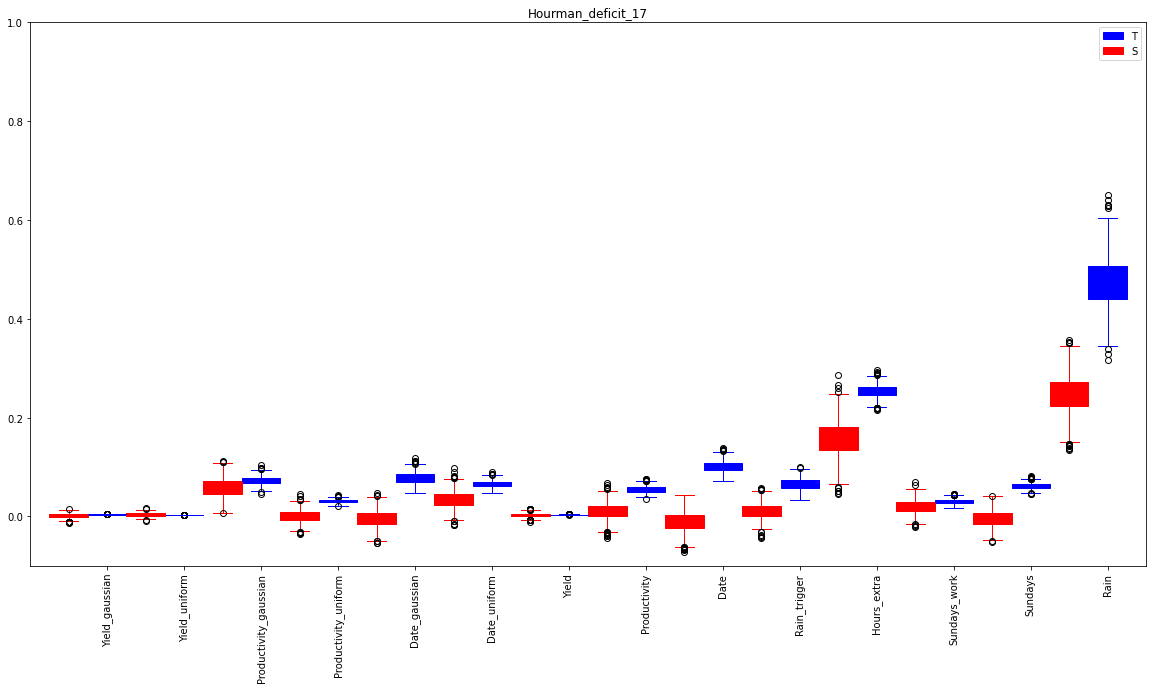

In [47]:
for eh,h in enumerate(Hourman_deficit_worker_list):
    fig, ax = plt.subplots(figsize=(20,10))
#     for iv,v in enumerate(variables):
#     ax.set_xticklabels(labels=variables,rotation='vertical')
    h[1].plot(kind='box',ax=ax,label='T', color='b',patch_artist=True)
#     To.plot(kind='box',label='T', color='b',patch_artist=True)
    h[0].plot(kind='box',ax=ax,label='S',positions=[iv+0.5 for iv in range(len(variables_no_Workers))],
                                              color='r',patch_artist=True)
#     S_output[it].plot(kind='box',ax=ax,label='S',
#                                               color='r',patch_artist=True)
    m_patch = mpatches.Patch(color='b', label='T')
    c_patch = mpatches.Patch(color='r', label='S')
    plt.xticks([iv+1 for iv in range(len(variables_no_Workers))],
               labels=variables_no_Workers,rotation='vertical')
    plt.legend(handles=[m_patch,c_patch])
    plt.xlim(0,14.5)
    plt.ylim(-.1,1)
    plt.title(output_list[it].columns[it]+'_'+str(Hourman_deficit_worker_df.columns[eh]))
    fig = plt.plot(figsize=(20,10),dpi=1000)
    plt.show()

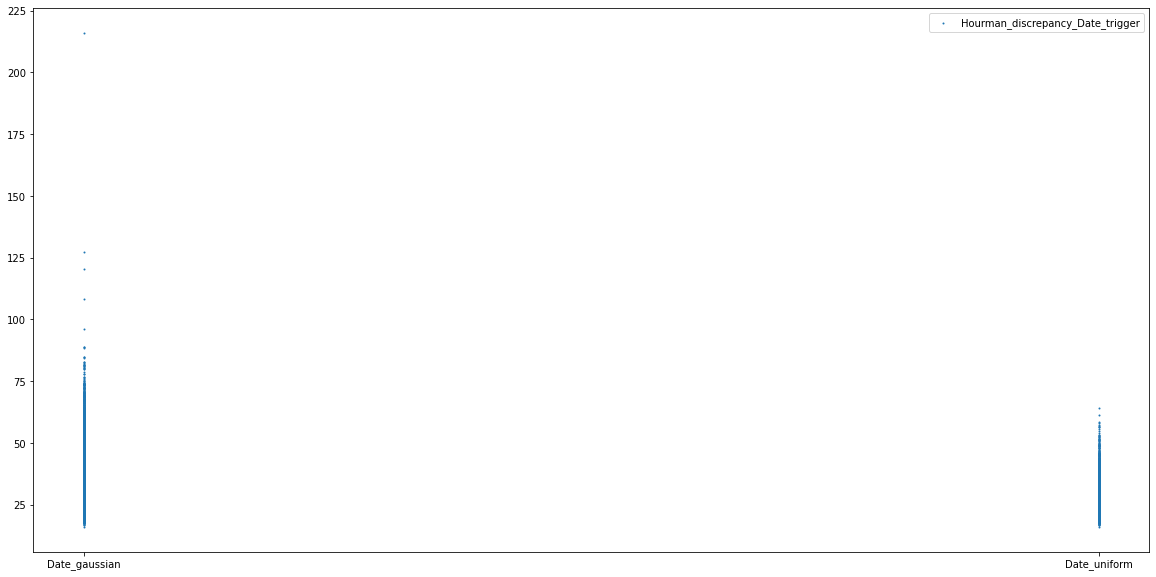

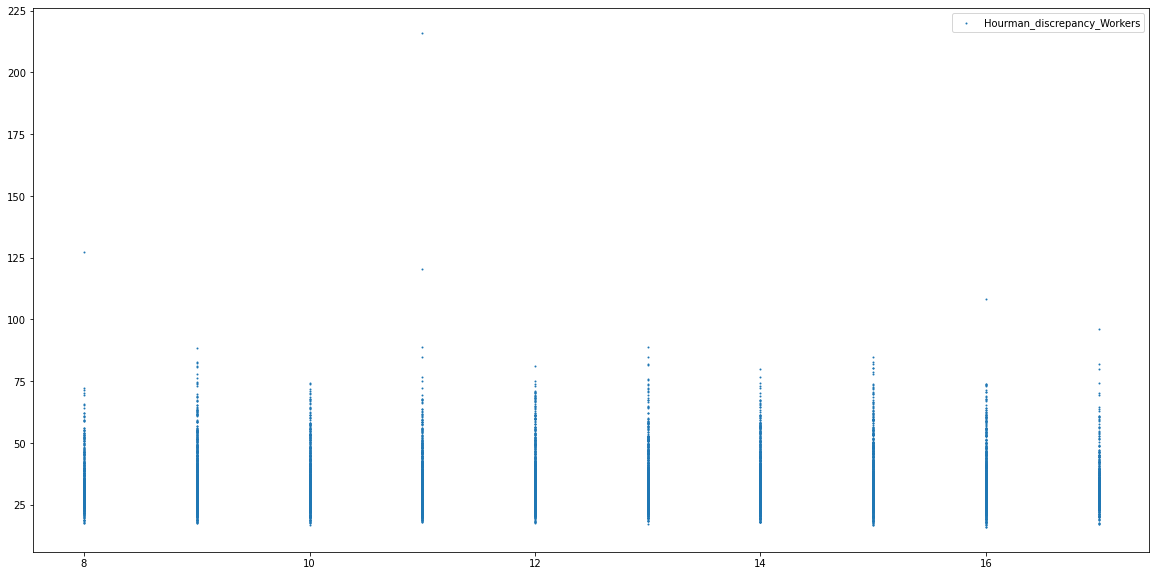

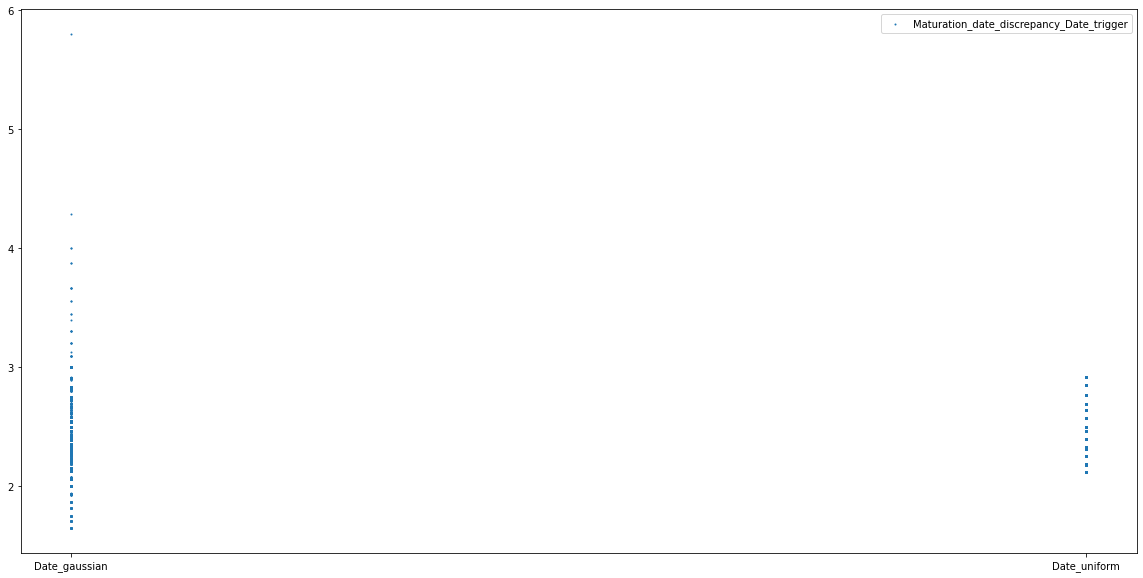

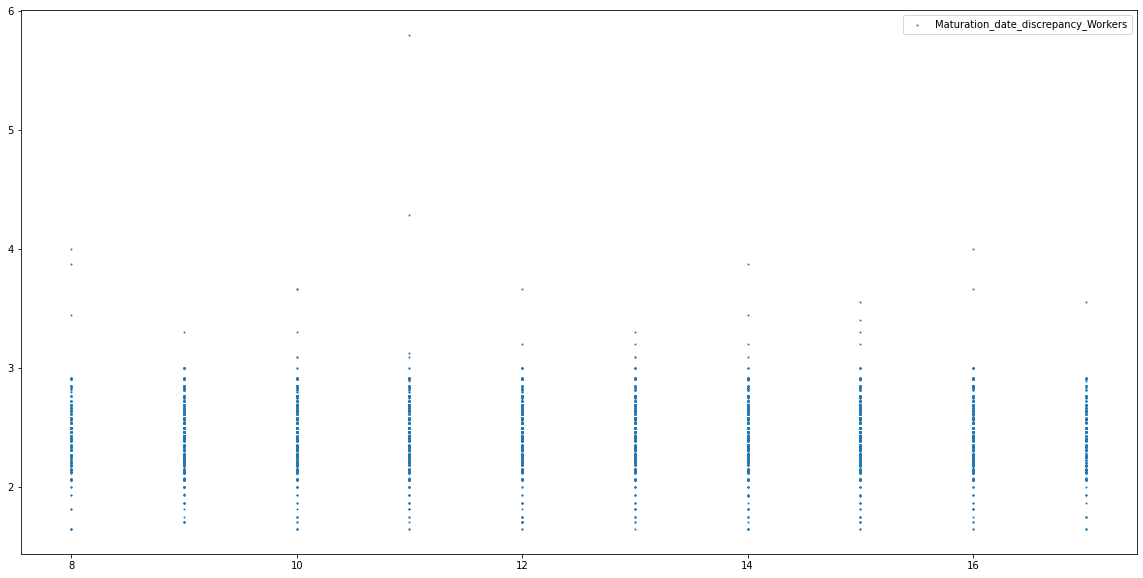

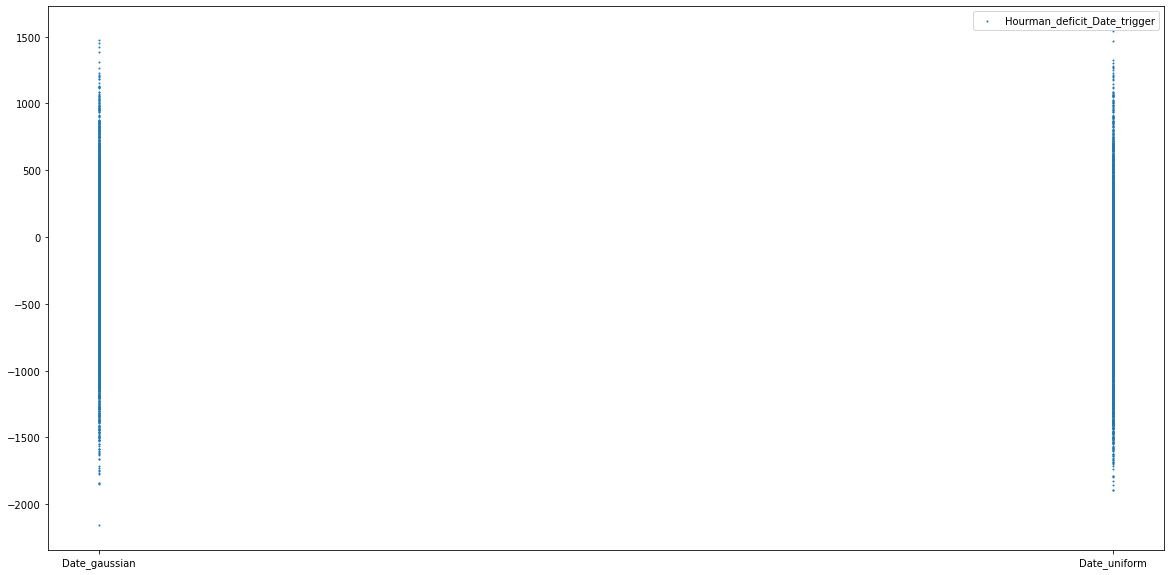

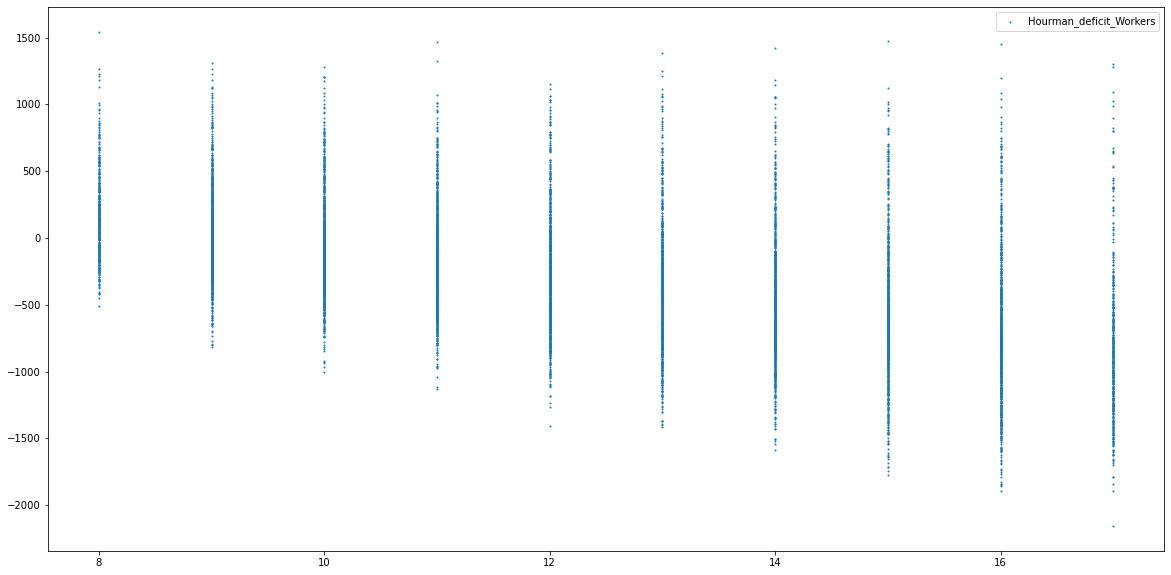

In [48]:
variables_reduced = ['Date_trigger','Workers']
for To in output.columns:
    for iv,v in enumerate(variables_reduced):
        plt.figure(figsize=(20,10))
        plt.scatter(sM_A[0][v].loc['vigneto 1'],output_list[0][To],s = 1,label=To+'_'+v)
        plt.legend()
        plt.show()